In [2]:
import os
import pickle
from glob import glob
from tqdm.notebook import tqdm
from scipy.io import loadmat

import numpy as np
import pandas as pd

from PIL import Image
from rembg import remove
import cv2

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split as tts

from scipy.stats import mannwhitneyu as mnu
from scipy.stats import wilcoxon
from scipy.stats import chisquare

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

from sklearn.preprocessing import scale

import warnings
warnings.filterwarnings('ignore')

c:\Users\user.JAJLAB2\Apps\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


# Definitions

In [3]:
def compute_vis_features(img_path):
    '''
    Definitions:
        circularity (roundness) = (4π×Area)/(Perimeter**2)
        elongation = 1 - (F_min/F_max)
        spikiness = 1 - (Obj_area/convex_area)
    Args:
        img_path:   "directory/name" of the image file
    Returns:
        circularity: circularity value
        elongation:  elongation value
        spikiness:   spikiness value
        contrast:    contrast value
    '''

    _, img = cv2.threshold(cv2.imread(img_path), 1,255, cv2.THRESH_BINARY)
    contrast = np.nanstd(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        contour = max(contours, key=cv2.contourArea)

        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = (4 * np.pi * area) / (perimeter**2) if perimeter>0 else 0

        _,_, width, height = cv2.boundingRect(contour)
        elongation = 1 - (min(width,height) / max(width,height)) if min(width,height)>0 else 0

        area_convex_hull = cv2.contourArea(cv2.convexHull(contour))
        spikiness = 1 - (area/area_convex_hull) if area_convex_hull>0 else 0
    else:
        circularity, elongation, spikiness, area = None, None, None, None
    
    return circularity, elongation, spikiness, contrast, area



In [18]:
FigDir = '../Results/physical_feature/'

ind_stim = np.concatenate((np.arange(2,180,6), [186,188,193,196,197], np.arange(200,500)), axis=0)
stim_info = pd.read_excel('../utils/stim_info.xlsx')
# # stim_info.head()

SaveDir = '../utils/StimSet_NoBG/'

stimset_path = '../utils/StimSet'
img_names = sorted(glob(os.path.join(stimset_path, '*.*')))
# print(len(img_names))
# print(img_names[0])

ind_animate = np.arange(175)
ind_inanimate = np.arange(175,335)
ind_face = np.arange(35)
ind_body = np.arange(35,75)

In [19]:
MatFeatures_dir = '../utils/vis_feature_mat.mat'
mat_features = loadmat(MatFeatures_dir)

cat_inds = mat_features['cat_inds'].T
cat_legends = []
for icat in range(cat_inds.shape[0]):
    cat_legends.append(mat_features['cat_legends'][0][icat][0])

sf_freqs = mat_features['sf_freqs'][0]
sf_profile = mat_features['sf_profile']

contrast_mat = mat_features['Contrast'][0]
Luminance = mat_features['Luminance'][0]
# objArea = mat_features['objArea'][0]

In [20]:
flat_im = []
for img in img_names:
    flat_im.append(cv2.cvtColor(cv2.threshold(cv2.imread(img), 1,255, cv2.THRESH_BINARY)[1], cv2.COLOR_BGR2GRAY).reshape(1,-1)[0])
flat_im = np.array(flat_im)

im_pca = PCA(n_components=2)
conv_im = im_pca.fit_transform(flat_im)

if 0:
    plt.figure(figsize=(3,2))
    plt.scatter(conv_im[:,0], conv_im[:,1])
    plt.tight_layout()
    print(f'Explained variance: {im_pca.explained_variance_ratio_}')

In [ ]:
# remove backgrounds
if 0:
    for im_name in tqdm(img_names):
        remove(Image.open(im_name)).save(f'{SaveDir}/{im_name[-7:]}')

stimset_path = SaveDir
img_names = sorted(glob(os.path.join(stimset_path, '*.*')))
# img_names[0]

circularities, elongations, spikiness, contrast, objArea = [], [], [], [], []
for im_name in tqdm(img_names):
        circularities.append(compute_vis_features(im_name)[0])
        elongations.append(compute_vis_features(im_name)[1])
        spikiness.append(compute_vis_features(im_name)[2])
        contrast.append(compute_vis_features(im_name)[3])
        objArea.append(compute_vis_features(im_name)[4])

feat_py = pd.DataFrame(data=np.array([circularities,elongations,spikiness,contrast]).T, columns=[['circ','elong', 'spike', 'contrast']])
feat_py['contrast'] = scale(feat_py['contrast'])
feat_py['pc1'] = conv_im[:,0]
feat_py['pc2'] = conv_im[:,1]

feat_py['objArea'] = objArea

feat_py.head(3)

# feat_py.to_csv('../utils/vis_feature_py.csv')

  0%|          | 0/335 [00:00<?, ?it/s]

  0%|          | 0/335 [00:00<?, ?it/s]

In [6]:
target = np.array(pd.get_dummies(stim_info['anim'].iloc[ind_stim], drop_first=True, dtype=int).reset_index().drop('index', axis=1))
feats = np.array(feat_py[['circ', 'elong', 'spike', 'contrast']])
# feats = np.array(feat_py['circ'])

np.random.seed(15)
n_epochs = 200
accuracy = []
for i_epoch in range(n_epochs):
    x_trn, x_tst, y_trn, y_tst = tts(feats, target, test_size=0.3, shuffle=True)
    mdl_lda = LDA().fit(x_trn, y_trn)
    tmp_accuracy = (mdl_lda.predict(x_tst) == y_tst.T).sum() / y_tst.T.shape[1]
    accuracy.append((tmp_accuracy * 100))

accuracy = np.array(accuracy)
print(f'Mean -+ SD = {np.nanmean(accuracy).round(2)} -+ {np.nanstd(accuracy).round(2)}')

Mean -+ SD = 63.64 -+ 4.09


WilcoxonResult(statistic=0.0, pvalue=0.0)
%50 zscore = -3.33


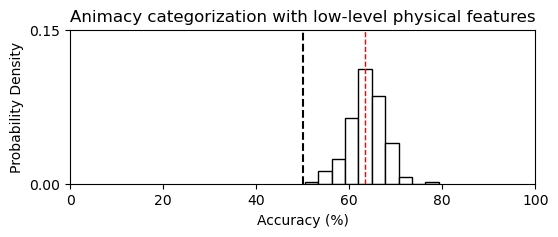

In [7]:
fig_sz = np.array((3,1)) * 2
plot_ylim = [0,.15]

plt.figure(figsize=fig_sz)
plt.hist(accuracy, color='w', edgecolor='k', bins=10, density=True)
plt.title('Animacy categorization with low-level physical features')

plt.axvline(50, ls='--', color='k', lw=fig_sz[0]/4)
plt.axvline(np.nanmedian(accuracy), ls='--', color='r', lw=fig_sz[0]/6)

plt.xlabel('Accuracy (%)')
plt.xlim([0,100])
# plt.xticks([0,20,40,50,60,80,100])

plt.ylabel('Probability Density')
plt.ylim(plot_ylim)
plt.yticks(plot_ylim)

print(f"{wilcoxon(accuracy-50, nan_policy='omit', method='exact', zero_method='zsplit')}")
print(f"%50 zscore = {((50 - np.nanmean(accuracy)) / np.nanstd(accuracy)).round(2)}")

# plt.savefig(f'{FigDir}physical_feature_classifier_stat.svg')

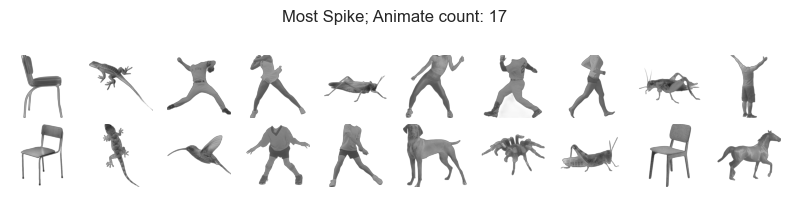

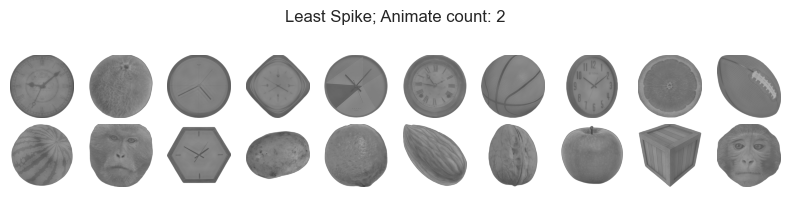

In [29]:
feat_of_interest = 'spike'
counts = 20
nrows = 2
ncols = int(counts/nrows)
fig_sz = np.array((4,1)) * 2

feat_most_idx = np.argsort(-feat_py[feat_of_interest], axis=0)
feat_less_idx = np.argsort(feat_py[feat_of_interest], axis=0)

feat_most_imgs = [img_names[im] for im in feat_most_idx[:counts,0]]
feat_less_imgs = [img_names[im] for im in feat_less_idx[:counts,0]]

fig1, axs1 = plt.subplots(figsize=fig_sz, nrows=nrows, ncols=ncols)
fig2, axs2 = plt.subplots(figsize=fig_sz, nrows=nrows, ncols=ncols)

for ax,im in zip(axs1.flatten(), feat_most_imgs):
    ax.imshow(np.array(Image.open(im)))
    ax.axis('off')
fig1.suptitle(f'Most {feat_of_interest.capitalize()}; Animate count: {(feat_most_idx[:counts,0]<175).sum()}')
fig1.tight_layout()

for ax,im in zip(axs2.flatten(), feat_less_imgs):
    ax.imshow(np.array(Image.open(im)))
    ax.axis('off')
fig2.suptitle(f'Least {feat_of_interest.capitalize()}; Animate count: {(feat_less_idx[:counts,0]<175).sum()}')
fig2.tight_layout()

# fig1.savefig(f'{FigDir}most_{feat_of_interest}_objects.svg')
# fig2.savefig(f'{FigDir}least_{feat_of_interest}_objects.svg')

In [9]:
feat_most_num_inanim = (feat_most_idx[:175] >= 175).sum()
feat_most_num_anim = (feat_most_idx[:175] < 175).sum()

print(f'X2 test: {chisquare([feat_most_num_inanim,feat_most_num_anim])}')
print(f"Mann-Whitney test: {mnu(feat_py[feat_of_interest][:175], feat_py[feat_of_interest][175:], nan_policy='omit')}")


X2 test: Power_divergenceResult(statistic=18.565714285714286, pvalue=1.641464317006442e-05)
Mann-Whitney test: MannwhitneyuResult(statistic=array([19097.]), pvalue=array([8.61762743e-09]))


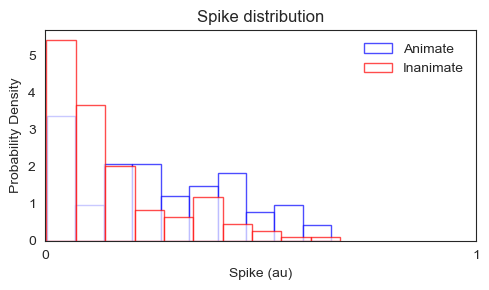

In [30]:
plot_ylim = [0,3]
fig_sz = (5,3)
plt.figure(figsize=(fig_sz))
plt.hist(feat_py[feat_of_interest][:175], color='w', edgecolor='b', alpha=.7, density=True, label='Animate')
plt.hist(feat_py[feat_of_interest][175:], color='w', edgecolor='r', alpha=.7, density=True, label='Inanimate')

plt.xlabel(f'{feat_of_interest.capitalize()} (au)')
plt.xlim([0,1])
plt.xticks([0,1])

plt.ylabel('Probability Density')
# plt.ylim(plot_ylim)
# plt.yticks(plot_ylim)

plt.title(f'{feat_of_interest.capitalize()} distribution')
plt.legend(frameon=False)
plt.tight_layout()

# plt.hist(accuracy, color='w', edgecolor='k', bins=10, density=True)

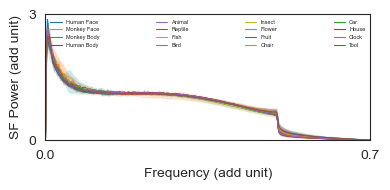

In [11]:
fg_sz = np.array([2,1]) * 2
plt_xlim = [0,.7]
plt_ylim = [0,3]

sns.set_style('white')
plt.figure(figsize=fg_sz)

for inds,cat in zip(cat_inds, cat_legends):
    plt.plot(sf_freqs, np.nanmean(sf_profile[inds[0]-1:inds[1]], axis=0), lw=fg_sz[0]/5, label=cat)
    plt.fill_between(sf_freqs, np.nanmean(sf_profile[inds[0]:inds[1]], axis=0) - np.nanstd(sf_profile[inds[0]:inds[1]], axis=0), 
                     np.nanmean(sf_profile[inds[0]:inds[1]], axis=0) + np.nanstd(sf_profile[inds[0]:inds[1]], axis=0), alpha=.3, label='_nolegend_')

plt.xlabel('Frequency (add unit)')
plt.xlim(plt_xlim)
plt.xticks(plt_xlim)

plt.ylabel('SF Power (add unit)')
plt.ylim(plt_ylim)
plt.yticks(plt_ylim)

plt.legend(frameon=False, fontsize=fg_sz[0], mode="expand", ncol=4)
plt.tight_layout()

# plt.savefig(f'{FigDir}physical_feature_sf_profile.svg')

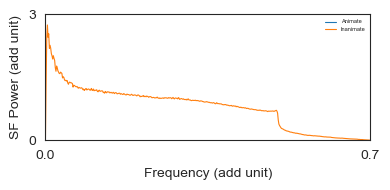

In [12]:
fg_sz = np.array([2,1]) * 2
plt_xlim = [0,.7]
plt_ylim = [0,3]

sns.set_style('white')
plt.figure(figsize=fg_sz)

if 1:
    cat_inds_sub = [ind_animate, ind_inanimate]
    cat_leg_sub = ['Animate', 'Inanimate']
else:
    cat_inds_sub = [ind_animate, ind_inanimate]
    cat_leg_sub = ['Face', 'Body']

for inds,cat in zip(cat_inds_sub, cat_leg_sub):
    plt.plot(sf_freqs, np.nanmean(sf_profile[inds[0]-1:inds[1]], axis=0), lw=fg_sz[0]/5, label=cat)
    plt.fill_between(sf_freqs, np.nanmean(sf_profile[inds[0]:inds[1]], axis=0) - np.nanstd(sf_profile[inds[0]:inds[1]], axis=0), 
                     np.nanmean(sf_profile[inds[0]:inds[1]], axis=0) + np.nanstd(sf_profile[inds[0]:inds[1]], axis=0), alpha=.3, label='_nolegend_')

plt.xlabel('Frequency (add unit)')
plt.xlim(plt_xlim)
plt.xticks(plt_xlim)

plt.ylabel('SF Power (add unit)')
plt.ylim(plt_ylim)
plt.yticks(plt_ylim)

plt.legend(frameon=False, fontsize=fg_sz[0], ncol=1)
plt.tight_layout()

([<matplotlib.axis.YTick at 0x1b913c27c90>,
 [Text(0, 0.4, '0.40'), Text(0, 0.55, '0.55')])

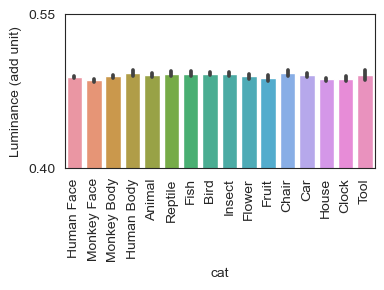

In [13]:
fg_sz = np.array([2,1]) * 2
plt_ylim = [.4,.55]

sns.set_style('white')
plt.figure(figsize=fg_sz)

Lum_df = pd.DataFrame(data=Luminance, columns=['Lum'])
Lum_df['cat'] = ''

for inds,cat in zip(cat_inds, cat_legends):
    Lum_df['cat'].iloc[inds[0]-1:inds[1]] = cat

Lum_bar = sns.barplot(Lum_df, x='cat', y='Lum', errorbar='sd') #, palette="coolwarm")
Lum_bar.set_xticklabels(Lum_bar.get_xticklabels(), rotation=90)

plt.ylabel('Luminance (add unit)')
plt.ylim(plt_ylim)
plt.yticks(plt_ylim)

# plt.savefig(f'{FigDir}physical_feature_luminance.svg')

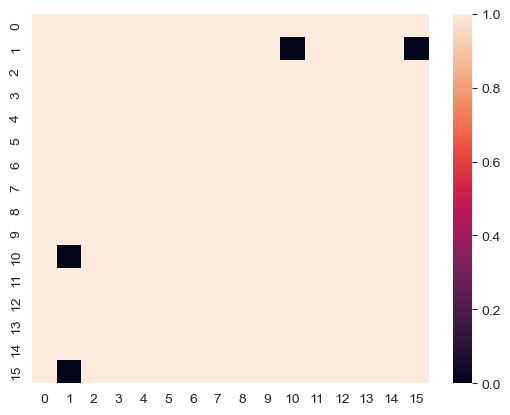

In [14]:
p_sig = .05

p_rows = []
for cat_i in Lum_df['cat'].unique():
    p_cols = []
    for cat_j in Lum_df['cat'].unique():
        p_cols.append(mnu(Lum_df['cat']==cat_i, Lum_df['cat']==cat_j, nan_policy='omit')[1])
    p_rows.append(np.array(p_cols))
p_rows = np.array(p_rows)

hm1 = sns.heatmap(p_rows>p_sig, cbar=True)
# plt.savefig(f'{FigDir}physical_feature_luminance_stat.svg')

MannwhitneyuResult(statistic=17772.0, pvalue=2.0490755046329037e-05)


(0.45, 0.5)

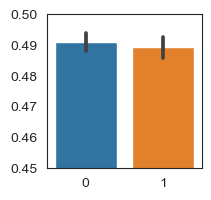

In [142]:
plt_ylim = [.45,.50]
cat_inds_sub = [ind_animate, ind_inanimate]

print(f"{mnu(Lum_df['Lum'].iloc[ind_animate], Lum_df['Lum'].iloc[ind_inanimate], nan_policy='omit')}")

plt.figure(figsize=(2,2))
sns.barplot([Lum_df['Lum'].iloc[ind_animate], Lum_df['Lum'].iloc[ind_inanimate]], estimator='median', errorbar='sd')
plt.ylim(plt_ylim)